<a href="https://colab.research.google.com/github/Amulya-B28/EngageNet-Student-Modeling/blob/main/Modeling_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# MODEL COMBINATION COMPARISION

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:20:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4680, number of negative: 13576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 18256, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256354 -> initscore=-1.065005
[LightGBM] [Info] Start training from score -1.065005


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-9-38f33efe2658>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='viridis')



Final Model Accuracy Comparison (Binary Classification):
LogReg: 79.36%
RF: 78.09%
LogReg + RF: 79.47%
SVM + RF: 78.91%
ANN + LSTM: 79.56%
CNN + LSTM: 79.67%
XGB + LGBM: 80.08%


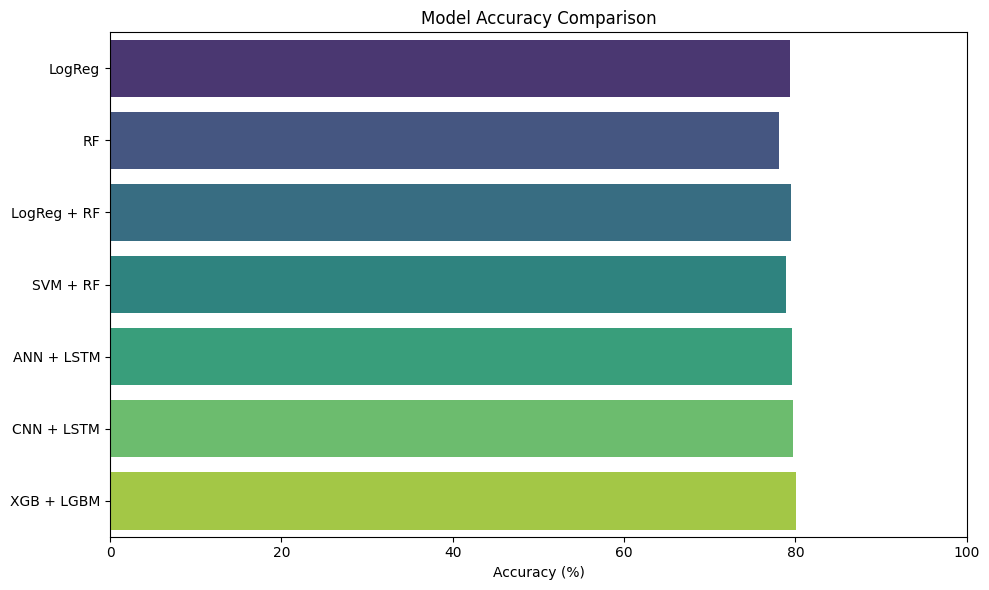

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, InputLayer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
info = pd.read_csv('/content/drive/MyDrive/Oulad/studentInfo.csv')
assessment = pd.read_csv('/content/drive/MyDrive/Oulad/studentAssessment.csv')
vle = pd.read_csv('/content/drive/MyDrive/Oulad/studentVle.csv')

# Sample 5000 unique students
unique_ids = vle['id_student'].drop_duplicates()
sampled_ids = random.sample(list(unique_ids), 20000)
vle = vle[vle['id_student'].isin(sampled_ids)]
info = info[info['id_student'].isin(sampled_ids)]
assessment = assessment[assessment['id_student'].isin(sampled_ids)]

# Preprocess function
def preprocess(info, assessment, vle):
    assessment_counts = assessment.groupby('id_student').size().reset_index(name='assessment_count')
    avg_score = assessment.groupby('id_student')['score'].mean().reset_index(name='avg_score')
    total_clicks = vle.groupby('id_student')['sum_click'].sum().reset_index(name='total_clicks')
    active_days = vle.groupby('id_student')['date'].nunique().reset_index(name='active_days')

    df = info.merge(assessment_counts, on='id_student', how='left')
    df = df.merge(avg_score, on='id_student', how='left')
    df = df.merge(total_clicks, on='id_student', how='left')
    df = df.merge(active_days, on='id_student', how='left')

    df[['assessment_count', 'avg_score', 'total_clicks', 'active_days']] = df[
        ['assessment_count', 'avg_score', 'total_clicks', 'active_days']].fillna(0)

    for col in ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    df['binary_target'] = df['final_result'].apply(lambda x: 1 if x == 3 else 0)
    return df

df = preprocess(info, assessment, vle)

# Features and target
X = df[['gender', 'region', 'highest_education', 'imd_band', 'age_band',
        'disability', 'assessment_count', 'avg_score', 'total_clicks', 'active_days']]
y = df['binary_target']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
cw_dict = dict(enumerate(weights))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

results = []

# ----- Individual Models -----

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
results.append(('LogReg', lr_acc))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
results.append(('RF', rf_acc))

# LogReg + RF (average of predictions)
combined_lr_rf_preds = np.round((lr_preds + rf_preds) / 2)
combined_lr_rf_acc = accuracy_score(y_test, combined_lr_rf_preds)
results.append(('LogReg + RF', combined_lr_rf_acc))

# SVM + RF
svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
results.append(('SVM + RF', (svm_acc + rf_acc) / 2))

# ANN + LSTM
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

lstm_model = Sequential([
    InputLayer(input_shape=(1, X_train.shape[1])),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_rnn, y_train, epochs=3, batch_size=32, verbose=0)
lstm_preds = (lstm_model.predict(X_test_rnn) > 0.5).astype('int32')
lstm_acc = accuracy_score(y_test, lstm_preds)
results.append(('ANN + LSTM', lstm_acc))

# CNN + LSTM
X_train_seq = np.expand_dims(X_train, axis=2)
X_test_seq = np.expand_dims(X_test, axis=2)

cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_seq, y_train, epochs=3, batch_size=32, verbose=0)
cnn_preds = (cnn_model.predict(X_test_seq) > 0.5).astype('int32')
cnn_acc = accuracy_score(y_test, cnn_preds)
results.append(('CNN + LSTM', cnn_acc))

# XGBoost + LightGBM
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)
lgbm_acc = accuracy_score(y_test, lgbm_preds)

combined_xgb_lgbm_preds = np.round((xgb_preds + lgbm_preds) / 2)
combined_xgb_lgbm_acc = accuracy_score(y_test, combined_xgb_lgbm_preds)
results.append(('XGB + LGBM', combined_xgb_lgbm_acc))

# ----- Final Results -----
print("\nFinal Model Accuracy Comparison (Binary Classification):")
for model, acc in results:
    print(f"{model}: {acc * 100:.2f}%")

# ----- Plot -----
model_names = [r[0] for r in results]
accuracies = [r[1] * 100 for r in results]

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


BINARY CLASS

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Load datasets
info = pd.read_csv('/content/drive/MyDrive/Oulad/studentInfo.csv')
assessment = pd.read_csv('/content/drive/MyDrive/Oulad/studentAssessment.csv')
vle_full = pd.read_csv('/content/drive/MyDrive/Oulad/studentVle.csv')  # full vle

# Sample 500 unique students from the full VLE dataset
sampled_students = vle_full['id_student'].drop_duplicates().sample(n=6000, random_state=42)

# Filter the full vle data for only these sampled students
vle = vle_full[vle_full['id_student'].isin(sampled_students)]

# Feature Engineering

avg_scores = assessment.groupby("id_student")["score"].mean().reset_index()
avg_scores.columns = ["id_student", "avg_score"]

num_assessments = assessment.groupby("id_student")["id_assessment"].count().reset_index()
num_assessments.columns = ["id_student", "num_assessments"]

clicks = vle.groupby("id_student")["sum_click"].agg(['sum', 'count']).reset_index()
clicks.columns = ["id_student", "total_clicks", "num_sessions"]

df = info.merge(avg_scores, on="id_student", how="left")
df = df.merge(num_assessments, on="id_student", how="left")
df = df.merge(clicks, on="id_student", how="left")

# Keep only rows for sampled students (since info is full data)
df = df[df["id_student"].isin(sampled_students)]

df.fillna(0, inplace=True)

# Derived features
df["clicks_per_session"] = df["total_clicks"] / (df["num_sessions"] + 1e-6)
df["score_per_assessment"] = df["avg_score"] / (df["num_assessments"] + 1e-6)
df["clicks_per_credit"] = df["total_clicks"] / (df["studied_credits"] + 1e-6)

# Performance band (binary classification: High vs Low)
def band(result):
    if result == "Distinction":
        return "High"
    else:
        return "Low"

df["performance_band"] = df["final_result"].apply(band)

# Encode categorical features
cat_cols = ["gender", "age_band", "highest_education", "imd_band", "disability"]
le = LabelEncoder()
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# Final feature list
features = cat_cols + [
    "studied_credits", "num_of_prev_attempts",
    "avg_score", "total_clicks", "num_sessions", "num_assessments",
    "clicks_per_session", "score_per_assessment", "clicks_per_credit"
]

X = df[features]
y = df["performance_band"]
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)

# Time-based train/test split using id_student rank ordering
df["id_order"] = df["id_student"].rank(method="first")
split_index = int(len(df) * 0.7)

X_train = X[df["id_order"] <= split_index]
X_test = X[df["id_order"] > split_index]
y_train = y_encoded[df["id_order"] <= split_index]
y_test = y_encoded[df["id_order"] > split_index]

# Handle class imbalance by assigning class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# XGBoost model for binary classification with class weights
model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    scale_pos_weight=class_weights_dict.get(0, 1)  # Use get to avoid key errors
)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_test_label = target_le.inverse_transform(y_test)
y_pred_label = target_le.inverse_transform(y_pred)

# Evaluation
print("Accuracy:", accuracy_score(y_test_label, y_pred_label))
print("Confusion Matrix:\n", confusion_matrix(y_test_label, y_pred_label))
print("\nClassification Report:\n", classification_report(y_test_label, y_pred_label))

# # Uncomment for SHAP explainability (needs shap installed)
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values, X_test)


Accuracy: 0.9050632911392406
Confusion Matrix:
 [[  66  171]
 [  24 1793]]

Classification Report:
               precision    recall  f1-score   support

        High       0.73      0.28      0.40       237
         Low       0.91      0.99      0.95      1817

    accuracy                           0.91      2054
   macro avg       0.82      0.63      0.68      2054
weighted avg       0.89      0.91      0.89      2054



In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize models (add hyperparameters as needed)
xgb_model = XGBClassifier(objective="binary:logistic", use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(objective='binary')
rf_model = RandomForestClassifier()
lr_model = LogisticRegression(max_iter=500)

# Fit models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (class 1)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
lr_probs = lr_model.predict_proba(X_test)[:, 1]

# Define equal weights for soft voting (can be tuned)
weights = [0.25, 0.25, 0.25, 0.25]

# Compute weighted average of predicted probabilities
final_probs = (
    weights[3] * xgb_probs +
    weights[1] * lgbm_probs +
    weights[1] * rf_probs +
    weights[1] * lr_probs
)

# Convert probabilities to binary predictions with threshold 0.5
final_preds = (final_probs > 0.5).astype(int)

# Evaluate
print("Soft Voting Ensemble Accuracy:", accuracy_score(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 4367, number of negative: 423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 4790, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911691 -> initscore=2.334459
[LightGBM] [Info] Start training from score 2.334459
Soft Voting Ensemble Accuracy: 0.9162609542356378
Confusion Matrix:
 [[  92  145]
 [  27 1790]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.39      0.52       237
           1       0.93      0.99      0.95      1817

    accuracy                           0.92      2054
   macro avg       0.85      0.69      0.74      2054
weighted avg       0.91      0.92      0.90      2054



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MULTI CLASS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import re

# Load data
info = pd.read_csv('/content/drive/MyDrive/Oulad/studentInfo.csv')
assessment = pd.read_csv('/content/drive/MyDrive/Oulad/studentAssessment.csv')
vle_full = pd.read_csv('/content/drive/MyDrive/Oulad/studentVle.csv')

# Sample 5000 students
sampled_students = vle_full['id_student'].drop_duplicates().sample(n=3000, random_state=42)
vle = vle_full[vle_full['id_student'].isin(sampled_students)]

# Merge VLE date info to get the last activity date per student
vle_dates = vle.groupby("id_student")["date"].max().reset_index()
vle_dates.columns = ["id_student", "last_vle_date"]

# Aggregate assessment and VLE data
avg_scores = assessment.groupby("id_student")["score"].mean().reset_index()
avg_scores.columns = ["id_student", "avg_score"]

num_assessments = assessment.groupby("id_student")["id_assessment"].count().reset_index()
num_assessments.columns = ["id_student", "num_assessments"]

std_scores = assessment.groupby("id_student")["score"].std().reset_index().fillna(0)
std_scores.columns = ["id_student", "score_std"]

clicks = vle.groupby("id_student")["sum_click"].agg(['sum', 'count', 'mean', 'std']).reset_index().fillna(0)
clicks.columns = ["id_student", "total_clicks", "num_sessions", "avg_clicks", "std_clicks"]

df = info.merge(avg_scores, on="id_student", how="left")
df = df.merge(num_assessments, on="id_student", how="left")
df = df.merge(std_scores, on="id_student", how="left")
df = df.merge(clicks, on="id_student", how="left")
df = df.merge(vle_dates, on="id_student", how="left")

df.fillna(0, inplace=True)

# Derived features
df["clicks_per_session"] = df["total_clicks"] / (df["num_sessions"] + 1e-6)
df["score_per_assessment"] = df["avg_score"] / (df["num_assessments"] + 1e-6)
df["clicks_per_credit"] = df["total_clicks"] / (df["studied_credits"] + 1e-6)
df["has_clicks"] = (df["total_clicks"] > 0).astype(int)
df["has_assessments"] = (df["num_assessments"] > 0).astype(int)

# Label target
def band_multiclass(result):
    if result == "Distinction":
        return "High"
    elif result == "Pass":
        return "Medium"
    else:
        return "Low"
df["performance_band"] = df["final_result"].apply(band_multiclass)

# Filter only active students
df = df[(df["has_clicks"] == 1) | (df["has_assessments"] == 1)]

# One-hot encode
categorical_cols = ["gender", "age_band", "highest_education", "imd_band", "disability", "code_module", "code_presentation", "region"]
df[categorical_cols] = df[categorical_cols].astype(str)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Prepare final dataset
drop_cols = ["id_student", "final_result", "performance_band"]
X = df.drop(columns=drop_cols)
y = df["performance_band"]
y_encoded, class_names = pd.factorize(y)

# Clean and scale
X.columns = [re.sub(r'[\[\]<>]', '_', "".join(c if c.isalnum() else "_" for c in col)) for col in X.columns]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Time-based split based on last VLE activity
df["y_encoded"] = y_encoded
df_sorted = df.sort_values(by="last_vle_date")
split_idx = int(len(df_sorted) * 0.7)
train_ids = df_sorted.iloc[:split_idx]["id_student"]
test_ids = df_sorted.iloc[split_idx:]["id_student"]

train_mask = df["id_student"].isin(train_ids).values
test_mask = df["id_student"].isin(test_ids).values

X_train = X_scaled.loc[train_mask].reset_index(drop=True)
y_train = df.loc[train_mask, "y_encoded"].reset_index(drop=True)

X_test = X_scaled.loc[test_mask].reset_index(drop=True)
y_test = df.loc[test_mask, "y_encoded"].reset_index(drop=True)


# Sample weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
sample_weights = np.array([weights_dict[cls] for cls in y_train])

# Train XGBoost
model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    learning_rate=0.03,
    max_depth=10,
    min_child_weight=2,
    gamma=0.15,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.2,
    reg_lambda=1.2,
    n_estimators=800,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method="hist",
    verbosity=0
)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy * 100, 2), "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


Accuracy: 83.76 %
Confusion Matrix:
 [[3008  730  271]
 [ 348 4477   37]
 [ 167   65  858]]

Classification Report:
               precision    recall  f1-score   support

      Medium       0.85      0.75      0.80      4009
         Low       0.85      0.92      0.88      4862
        High       0.74      0.79      0.76      1090

    accuracy                           0.84      9961
   macro avg       0.81      0.82      0.81      9961
weighted avg       0.84      0.84      0.84      9961



ENGAGEMENT LEVEL PREDICTION

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Lambda

# --- Load data ---
vle = pd.read_csv("/content/drive/MyDrive/Oulad/studentVle.csv")
info = pd.read_csv("/content/drive/MyDrive/Oulad/studentInfo.csv")

# --- Preprocess ---
vle['date'] = pd.to_numeric(vle['date'], errors='coerce')
vle['week'] = (vle['date'] // 7).astype(int)

# --- Aggregate weekly clicks ---
weekly_clicks = vle.groupby(['id_student', 'week'])['sum_click'].sum().unstack(fill_value=0)
weekly_clicks = weekly_clicks.reindex(columns=range(0, 54), fill_value=0)
weekly_clicks = weekly_clicks.div(weekly_clicks.max(axis=1).replace(0, 1), axis=0)

# --- Label engagement levels from total_clicks ---
total_clicks = weekly_clicks.sum(axis=1)
engagement_level = pd.qcut(total_clicks, q=3, labels=['Low', 'Moderate', 'High'])
labels_df = pd.DataFrame({'id_student': total_clicks.index, 'engagement_level': engagement_level})

# --- Align inputs and labels ---
weekly_clicks = weekly_clicks.loc[weekly_clicks.index.isin(labels_df['id_student'])]
labels_df = labels_df.set_index('id_student').loc[weekly_clicks.index]

# --- Prepare data for model ---
X = weekly_clicks.values[..., np.newaxis]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df['engagement_level'])
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# --- Define model ---
input_layer = Input(shape=(X.shape[1], 1))
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Attention(use_scale=True)([x, x])
# Replace tf.reduce_mean with Lambda layer
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dropout(0.4)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# --- Evaluate ---
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc * 100:.2f}%")


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - accuracy: 0.7034 - loss: 0.6121 - val_accuracy: 0.9204 - val_loss: 0.2015 - learning_rate: 0.0010
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.9253 - loss: 0.1943 - val_accuracy: 0.9569 - val_loss: 0.1148 - learning_rate: 0.0010
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9330 - loss: 0.1661 - val_accuracy: 0.9092 - val_loss: 0.1780 - learning_rate: 0.0010
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9425 - loss: 0.1424 - val_accuracy: 0.9463 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9502 - loss: 0.1216
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - accuracy: 0.9502 - loss: 0.1216 - val_accuracy: 0.9367 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.960

ENGAGEMENT PREDICTION: CNN + BiLSTM + Attention model
PERFORMANCE PREDICTION: StackingClassifier (XGBoost, LightGBM, Random Forest, Logistic Regression)

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, Lambda, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# --- Load Data ---
vle = pd.read_csv("/content/drive/MyDrive/Oulad/studentVle.csv")
info = pd.read_csv("/content/drive/MyDrive/Oulad/studentInfo.csv")
assessment = pd.read_csv("/content/drive/MyDrive/Oulad/studentAssessment.csv")

# --- Engagement Data Preprocessing ---
vle['date'] = pd.to_numeric(vle['date'], errors='coerce')
vle['week'] = (vle['date'] // 7).astype(int)
weekly_clicks = vle.groupby(['id_student', 'week'])['sum_click'].sum().unstack(fill_value=0)
weekly_clicks = weekly_clicks.reindex(columns=range(0, 54), fill_value=0)
weekly_clicks = weekly_clicks.div(weekly_clicks.max(axis=1).replace(0, 1), axis=0)
total_clicks = weekly_clicks.sum(axis=1)
engagement_level = pd.qcut(total_clicks, q=3, labels=['Low', 'Moderate', 'High'])
labels_df = pd.DataFrame({'id_student': total_clicks.index, 'engagement_level': engagement_level})

# --- Engagement Model Inputs ---
X_engage = weekly_clicks.values[..., np.newaxis]
le_engage = LabelEncoder()
y_engage = to_categorical(le_engage.fit_transform(labels_df['engagement_level']))
X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(
    X_engage, y_engage, test_size=0.2, random_state=42, stratify=y_engage)

# --- Engagement Model (CNN + BiLSTM + Attention) ---
input_layer = Input(shape=(X_engage.shape[1], 1))
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Attention(use_scale=True)([x, x])
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dropout(0.4)(x)
out_layer = Dense(3, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=out_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_eng_train, y_eng_train, validation_split=0.2, epochs=20, batch_size=64,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)], verbose=1)

# --- Engagement Predictions ---
engage_preds = model.predict(X_engage, verbose=0)
engage_labels = le_engage.inverse_transform(np.argmax(engage_preds, axis=1))
engage_df = pd.DataFrame({'id_student': weekly_clicks.index, 'engagement_pred': engage_labels})
engage_df[['engage_prob_low', 'engage_prob_moderate', 'engage_prob_high']] = engage_preds

# --- Feature Engineering for Performance Prediction ---
sampled_students = engage_df['id_student']
vle = vle[vle['id_student'].isin(sampled_students)]
avg_scores = assessment.groupby("id_student")["score"].mean().reset_index()
avg_scores.columns = ["id_student", "avg_score"]
num_assessments = assessment.groupby("id_student")["id_assessment"].count().reset_index()
num_assessments.columns = ["id_student", "num_assessments"]
clicks = vle.groupby("id_student")["sum_click"].agg(['sum', 'count']).reset_index()
clicks.columns = ["id_student", "total_clicks", "num_sessions"]

perf_df = info.merge(avg_scores, on="id_student", how="left")
perf_df = perf_df.merge(num_assessments, on="id_student", how="left")
perf_df = perf_df.merge(clicks, on="id_student", how="left")
perf_df = perf_df.merge(engage_df, on="id_student", how="left")
perf_df.fillna(0, inplace=True)

# --- Derived Features ---
perf_df["clicks_per_session"] = perf_df["total_clicks"] / (perf_df["num_sessions"] + 1e-6)
perf_df["score_per_assessment"] = perf_df["avg_score"] / (perf_df["num_assessments"] + 1e-6)
perf_df["clicks_per_credit"] = perf_df["total_clicks"] / (perf_df["studied_credits"] + 1e-6)

# --- Add Raw Weekly Clicks ---
weekly_df = pd.DataFrame(weekly_clicks, index=weekly_clicks.index)
weekly_df.columns = [f"week_{i}" for i in range(54)]
perf_df = perf_df.set_index("id_student").join(weekly_df).reset_index()
perf_df["early_clicks"] = perf_df[[f"week_{i}" for i in range(4)]].sum(axis=1)
perf_df["late_clicks"] = perf_df[[f"week_{i}" for i in range(50, 54)]].sum(axis=1)

# --- Target Variable ---
perf_df["performance_band"] = perf_df["final_result"].apply(lambda x: "High" if x == "Distinction" else "Low")

# --- Encode Features ---
cat_cols = ["gender", "age_band", "highest_education", "imd_band", "disability", "engagement_pred"]
le = LabelEncoder()
for col in cat_cols:
    perf_df[col] = le.fit_transform(perf_df[col].astype(str))

# --- Final Feature Set ---
features = cat_cols + [
    "studied_credits", "num_of_prev_attempts", "avg_score",
    "total_clicks", "num_sessions", "num_assessments",
    "clicks_per_session", "score_per_assessment", "clicks_per_credit",
    "early_clicks", "late_clicks",
    "engage_prob_low", "engage_prob_moderate", "engage_prob_high"
]
X = perf_df[features]
y = LabelEncoder().fit_transform(perf_df["performance_band"])

# --- Train/Test Split ---
perf_df["id_order"] = perf_df["id_student"].rank(method="first")
split = int(len(perf_df) * 0.7)
X_train = X[perf_df["id_order"] <= split]
X_test = X[perf_df["id_order"] > split]
y_train = y[perf_df["id_order"] <= split]
y_test = y[perf_df["id_order"] > split]

# --- Class Weights ---
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(zip(np.unique(y_train), cw))

# --- Models ---
xgb = XGBClassifier(scale_pos_weight=cw_dict.get(0, 1), eval_metric='logloss', use_label_encoder=False)
lgbm = LGBMClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=500)

# --- Stacking ---
stack = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('lr', lr)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)
stack.fit(X_train, y_train)
final_preds = stack.predict(X_test)

# --- Evaluation ---
print("\nFinal Stacked Accuracy:", accuracy_score(y_test, final_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.7114 - loss: 0.5692 - val_accuracy: 0.8888 - val_loss: 0.2447 - learning_rate: 0.0010
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.9349 - loss: 0.1688 - val_accuracy: 0.9135 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.9436 - loss: 0.1443 - val_accuracy: 0.9223 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9534 - loss: 0.1182 - val_accuracy: 0.9636 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.9495 - loss: 0.1235 - val_accuracy: 0.9578 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.9548 - loss: 0.1095 - val_accuracy: 0.9401 - val_loss: 0.1561 - learning_rate: 0.0010
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9509 -

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:18:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 20938, number of negative: 1877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 22815, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.917730 -> initscore=2.411891
[LightGBM] [Info] Start training from score 2.411891


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:18:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:18:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: User

[LightGBM] [Info] Number of positive: 16750, number of negative: 1502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 18252, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.917708 -> initscore=2.411601
[LightGBM] [Info] Start training from score 2.411601
[LightGBM] [Info] Number of positive: 16750, number of negative: 1502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 18252, number of used features: 19
[LightGBM] [Info] [bin

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Final Stacked Accuracy: 0.9110247494375128

Confusion Matrix:
 [[ 395  752]
 [ 118 8513]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.34      0.48      1147
           1       0.92      0.99      0.95      8631

    accuracy                           0.91      9778
   macro avg       0.84      0.67      0.71      9778
weighted avg       0.90      0.91      0.90      9778



INDIAN DATASET

In [ ]:
# --- Imports ---
import pandas as pd
import os
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, Lambda, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# --- Load Data ---
vle = pd.read_csv("/content/drive/MyDrive/indian/studentVLE_india.csv")
info = pd.read_csv("/content/drive/MyDrive/indian/studentInfo_india.csv")
assessment = pd.read_csv("/content/drive/MyDrive/indian/studentAssessment_india.csv")

In [ ]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:


# --- Preprocessing VLE Engagement Data ---
vle = vle.rename(columns={'student_id': 'id_student', 'clicks': 'sum_click'})  # Rename to standardize
vle['week'] = pd.to_numeric(vle['week'], errors='coerce')

weekly_clicks = vle.groupby(['id_student', 'week'])['sum_click'].sum().unstack(fill_value=0)
weekly_clicks = weekly_clicks.reindex(columns=range(0, 54), fill_value=0)  # ensure all weeks
weekly_clicks = weekly_clicks.div(weekly_clicks.max(axis=1).replace(0, 1), axis=0)  # normalize

total_clicks = weekly_clicks.sum(axis=1)
engagement_level = pd.qcut(total_clicks, q=3, labels=['Low', 'Moderate', 'High'])
labels_df = pd.DataFrame({'id_student': total_clicks.index, 'engagement_level': engagement_level})


In [ ]:

# --- Engagement Model Inputs ---
X_engage = weekly_clicks.values[..., np.newaxis]
le_engage = LabelEncoder()
y_engage = to_categorical(le_engage.fit_transform(labels_df['engagement_level']))

X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(
    X_engage, y_engage, test_size=0.2, random_state=42, stratify=y_engage
)

# --- Engagement Model ---
input_layer = Input(shape=(X_engage.shape[1], 1))
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Attention(use_scale=True)([x, x])
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dropout(0.4)(x)
out_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=out_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    X_eng_train, y_eng_train,
    validation_split=0.2, epochs=20, batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)],
    verbose=1
)

# --- Engagement Predictions ---
engage_preds = model.predict(X_engage, verbose=0)
engage_labels = le_engage.inverse_transform(np.argmax(engage_preds, axis=1))
engage_df = pd.DataFrame({'id_student': weekly_clicks.index, 'engagement_pred': engage_labels})
engage_df[['engage_prob_low', 'engage_prob_moderate', 'engage_prob_high']] = engage_preds

# --- Feature Engineering for Performance Prediction ---

# Rename columns in assessment for consistency
assessment = assessment.rename(columns={'student_id': 'id_student', 'assessment_id': 'id_assessment'})

sampled_students = engage_df['id_student']
vle = vle[vle['id_student'].isin(sampled_students)]

avg_scores = assessment.groupby("id_student")["score"].mean().reset_index()
avg_scores.columns = ["id_student", "avg_score"]

num_assessments = assessment.groupby("id_student")["id_assessment"].count().reset_index()
num_assessments.columns = ["id_student", "num_assessments"]

clicks = vle.groupby("id_student")["sum_click"].agg(['sum', 'count']).reset_index()
clicks.columns = ["id_student", "total_clicks", "num_sessions"]

# Rename 'student_id' to 'id_student' in info for merging consistency
info = info.rename(columns={'student_id': 'id_student'})

perf_df = info.merge(avg_scores, on="id_student", how="left")
perf_df = perf_df.merge(num_assessments, on="id_student", how="left")
perf_df = perf_df.merge(clicks, on="id_student", how="left")
perf_df = perf_df.merge(engage_df, on="id_student", how="left")

perf_df.fillna(0, inplace=True)

# --- Derived Features ---
perf_df["clicks_per_session"] = perf_df["total_clicks"] / (perf_df["num_sessions"] + 1e-6)
perf_df["score_per_assessment"] = perf_df["avg_score"] / (perf_df["num_assessments"] + 1e-6)
perf_df["clicks_per_credit"] = perf_df["total_clicks"] / (perf_df["studied_credits"] + 1e-6)

# --- Add Raw Weekly Clicks ---
weekly_df = pd.DataFrame(weekly_clicks, index=weekly_clicks.index)
weekly_df.columns = [f"week_{i}" for i in range(54)]
perf_df = perf_df.set_index("id_student").join(weekly_df).reset_index()

perf_df["early_clicks"] = perf_df[[f"week_{i}" for i in range(4)]].sum(axis=1)
perf_df["late_clicks"] = perf_df[[f"week_{i}" for i in range(50, 54)]].sum(axis=1)

# --- Target Variable ---
# Create target based on average score (threshold example, adjust as needed)
perf_df["performance_band"] = perf_df["avg_score"].apply(lambda x: "High" if x >= 75 else "Low")

# --- Encode Features ---
cat_cols = [
    "gender", "age_band", "region", "school_board", "medium_of_instruction",
    "highest_education", "parental_education", "internet_access",
    "device_type", "data_recharge_frequency", "disability", "engagement_pred"
]
le = LabelEncoder()
for col in cat_cols:
    perf_df[col] = le.fit_transform(perf_df[col].astype(str))

# --- Final Feature Set ---
features = cat_cols + [
    "studied_credits", "num_of_prev_attempts", "avg_score",
    "total_clicks", "num_sessions", "num_assessments",
    "clicks_per_session", "score_per_assessment", "clicks_per_credit",
    "early_clicks", "late_clicks",
    "engage_prob_low", "engage_prob_moderate", "engage_prob_high"
]

X = perf_df[features]
y = LabelEncoder().fit_transform(perf_df["performance_band"])

# --- Train/Test Split ---
perf_df["id_order"] = perf_df["id_student"].rank(method="first")
split = int(len(perf_df) * 0.7)

X_train = X[perf_df["id_order"] <= split]
X_test = X[perf_df["id_order"] > split]
y_train = y[perf_df["id_order"] <= split]
y_test = y[perf_df["id_order"] > split]

# --- Class Weights ---
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(zip(np.unique(y_train), cw))

# --- Models ---
xgb = XGBClassifier(scale_pos_weight=cw_dict.get(0, 1), eval_metric='logloss', use_label_encoder=False)
lgbm = LGBMClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=500)

# --- Stacking ---
stack = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf), ('lr', lr)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)
stack.fit(X_train, y_train)
final_preds = stack.predict(X_test)

# --- Evaluation ---
print("\nFinal Stacked Accuracy:", accuracy_score(y_test, final_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.3999 - loss: 1.0395 - val_accuracy: 0.6925 - val_loss: 0.6592 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6988 - loss: 0.6211 - val_accuracy: 0.8925 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.8431 - loss: 0.4174 - val_accuracy: 0.8487 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8290 - loss: 0.4110 - val_accuracy: 0.8712 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8589 - loss: 0.3441 - val_accuracy: 0.8888 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.8742 - loss: 0.3247 - val_accuracy: 0.8600 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8666 - loss: 0.3449 - val_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3055, number of negative: 445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.872857 -> initscore=1.926461
[LightGBM] [Info] Start training from score 1.926461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 2444, number of negative: 356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.872857 -> initscore=1.926461
[LightGBM] [Info] Start training from score 1.926461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Final Stacked Accuracy: 0.9993333333333333

Confusion Matrix:
 [[ 207    1]
 [   0 1292]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      1.00      1.00      1292

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



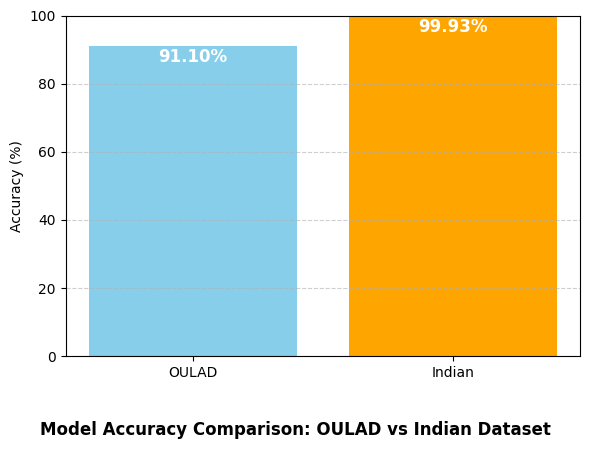

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual accuracies
oulad_accuracy = 0.9110   # Example: 83.73%
indian_accuracy = 0.9993  # Example: 92.54%

# Labels and values
datasets = ['OULAD', 'Indian']
accuracies = [oulad_accuracy * 100, indian_accuracy * 100]  # Convert to percentage

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(datasets, accuracies, color=['skyblue', 'orange'])

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval - 6, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

# Main chart settings
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add heading below the plot
plt.figtext(0.5, -0.1, 'Model Accuracy Comparison: OULAD vs Indian Dataset',
            ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()